# **Anomaly Detection con fattorizzazione NMF**

Questo Notebook mostra come utilizzare la ***Non-Negative Matrix Factorization*** (NMF) per la risoluzione di un problema di anomaly detection su immagini industriali.

## **Fase 1:** Caricamento del dataset

In [3]:
from utils.image import FSRandomImageGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from numpy.linalg import lstsq
from utils.plot import ROC

In [4]:
target_shape = (150, 150, 1)

# Training set
train_data_path = "./mvtec_bottle_dataset/train/good/*.*"
train_generator = FSRandomImageGenerator(data_path=train_data_path, image_shape=target_shape)
train_set = train_generator.get_all()
print("Training set size:", len(train_set))

# Test set
test_data_path = "./mvtec_bottle_dataset/test/good/*.*"
test_generator = FSRandomImageGenerator(data_path=test_data_path, image_shape=target_shape)
test_set = test_generator.get_all()
print("Test set size:", len(test_set))

# Anomaly set
broken_data_path = "./mvtec_bottle_dataset/anomalies/broken/*.*"
broken_large_data_path = "./mvtec_bottle_dataset/anomalies/broken_large/*.*"
contamination_data_path = "./mvtec_bottle_dataset/anomalies/contamination/*.*"
anomalies_generator = FSRandomImageGenerator([broken_data_path, broken_large_data_path, contamination_data_path], image_shape=target_shape)
anom_set = anomalies_generator.get_all()
print("Anomaly set size:", len(anom_set))

Training set size: 209
Test set size: 20
Anomaly set size: 63


Esempio di immagini *normali* (bottiglie sane):

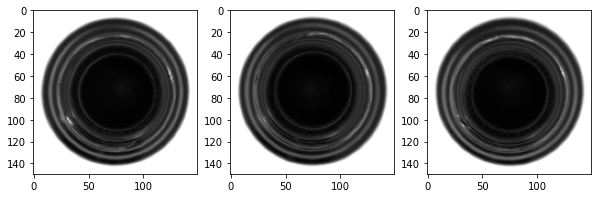

In [7]:
plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(train_set[i].reshape(target_shape[:2]), cmap="gray")

Esempio di immagini *anomale* (bottiglie difettose):

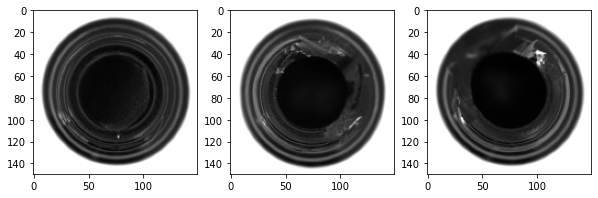

In [9]:
plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(anom_set[i].reshape(target_shape[:2]), cmap="gray")

### **1.1:** Manipolazione del dataset di training

Composizione della matrice dei dati **X**.

In [10]:
# numero di righe della matrice
n_rows = target_shape[0] * target_shape[1]
# numero di colonne della matrice
n_cols = len(train_set)

X = np.zeros(shape = (n_rows, n_cols))

for i, img in enumerate(train_set):
    # ogni colonna di X contiene una immagine del dataset di training
    X[:, i] = img.reshape(n_rows)

print(X.shape)

(22500, 209)


## **Fase 2:** Fattorizzazione NMF 

Test con 10 componenti

In [11]:
model = NMF(n_components=10, init='nndsvd',
            tol = 0.1, 
            alpha = 0.1, l1_ratio = 0.8,
            solver = "cd",
            beta_loss = "frobenius")
W = model.fit_transform(X)

print(W.shape)

(22500, 10)


Plot delle ***auto-immagini***

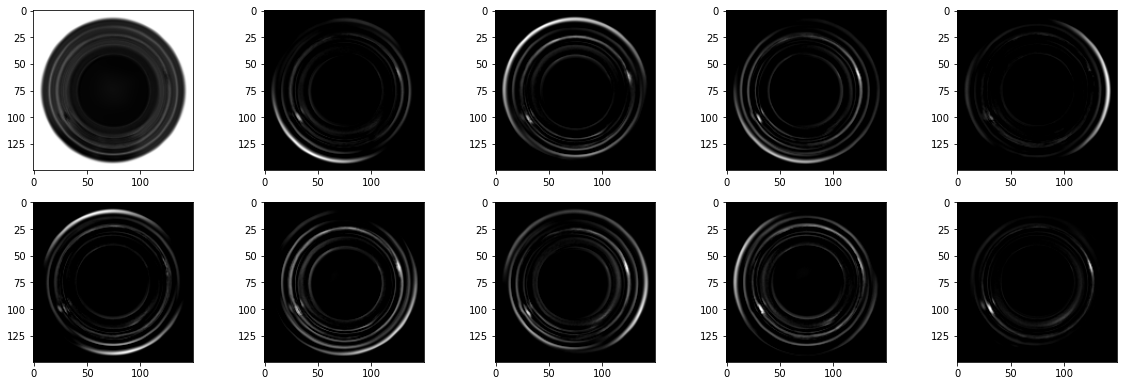

In [12]:
plt.figure(figsize=(20,10))
columns = 5
for i in range(10):
   plt.subplot(10/ columns + 1, columns, i + 1)
   plt.imshow(W[:,i].reshape(target_shape[0], target_shape[1]), cmap='gray')

Test di ricostruzione con 10 autoimmagini

In [13]:
# immagine di esempio
test_img = test_set[0]
test_img = test_img.reshape((n_rows, 1))
test_img.shape

(22500, 1)

In [14]:
# Calcolo del vettore dei coefficenti
sol = lstsq(W, test_img, rcond=None)
coeff = sol[0]
# errore residuo
residual = sol[1]
print("Residual:", residual)

print("Coefficient shape:", coeff.shape)

# Calcolo dell'immagine ricostruita
rec = np.dot(W, coeff)
print("Recostruction shape:", rec.shape)

Residual: [19.60751436]
Coefficient shape: (10, 1)
Recostruction shape: (22500, 1)


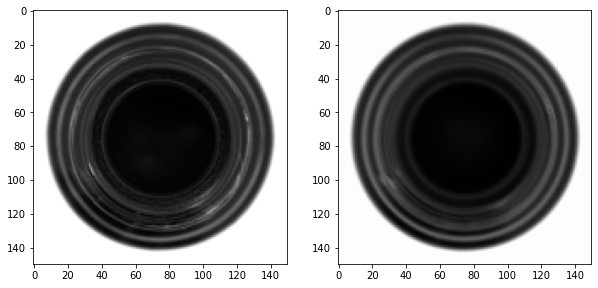

In [15]:
# Visualizzazione
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(test_img.reshape(target_shape[0], target_shape[1]), cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(rec.reshape(target_shape[0], target_shape[1]), cmap="gray")

Test su immagine anomala

Residual: [28.46150053]


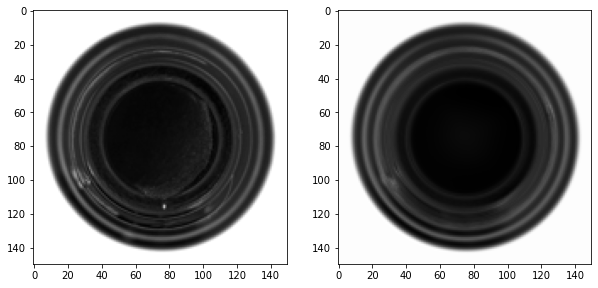

In [16]:
plt.figure(figsize=(10,10))

anom_img = anom_set[0]
anom_img = anom_img.reshape((n_rows, 1))

sol = lstsq(W, anom_img, rcond=None)
x = sol[0]
residual = sol[1]
print("Residual:", residual)
rec = np.dot(W, x)

plt.subplot(1, 2, 1)
plt.imshow(anom_img.reshape(target_shape[0], target_shape[1]), cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(rec.reshape(target_shape[0], target_shape[1]), cmap="gray")

## **Fase 3:** Valutazione del modello

Calcolo degli errori di ricostruzione sulle immagini di test

In [17]:
test_errors = []
for test_img in test_set:
    test_img = test_img.reshape(n_rows, 1)
    residual = lstsq(W, test_img, rcond=None)[1][0]
    test_errors.append(residual)

min_test_err = min(test_errors)
max_test_err = max(test_errors)

print("min. error =", min_test_err)
print("max. error =", max_test_err)

min. error = 13.780553351741634
max. error = 27.740380558148495


Calcolo degli errori di ricostruzione sulle anomalie

In [18]:
anom_errors = []
for anom_img in anom_set:
    anom_img = anom_img.reshape(n_rows, 1)
    residual = lstsq(W, anom_img, rcond=None)[1][0]
    anom_errors.append(residual)

min_anom_err = min(anom_errors)
max_anom_err = max(anom_errors)

print("min. error =", min_anom_err)
print("max. error =", max_anom_err)

min. error = 16.037861572983587
max. error = 204.9848046899514


Plot della ROC

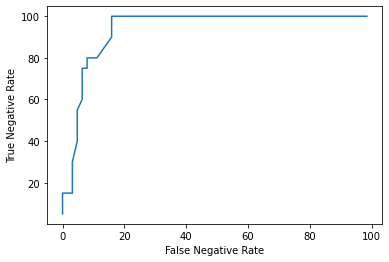

AUC = 92.26190476190473
Best point = (15.873015873015872, 100.0)
Best threshold = 27.984804689951403


In [19]:
roc = ROC(test_errors, anom_errors, max(max_test_err, max_anom_err) , min(min_test_err, min_anom_err), 0.5)
roc.plot(draw_th=False, line_type='-')

print("AUC =", roc.AUC())
top_left_point, top_left_th = roc.top_left()
print("Best point =", top_left_point)
print("Best threshold =", top_left_th)

Test con 100 autoimmagini

Done.
min. = 6.930279821719
max. = 16.81503604212164
min. = 9.004798701004274
max. = 192.24898848701588


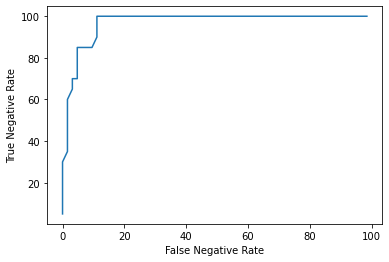

AUC = 95.35714285714285
Best point = (11.11111111111111, 100.0)
Best threshold = 17.1489884870225


In [26]:
model = NMF(100, init='nndsvd', solver="cd", beta_loss="frobenius", tol = 0.1, alpha = 0.1,  l1_ratio=0.8)
W = model.fit_transform(X)
print("Done.")

test_errors = []
for test_img in test_set:
    test_img = test_img.reshape(n_rows, 1)
    residual = lstsq(W, test_img, rcond=None)[1][0]
    test_errors.append(residual)

min_test_err = min(test_errors)
max_test_err = max(test_errors)

print("min. =", min_test_err)
print("max. =", max_test_err)

anom_errors = []
for anom_img in anom_set:
    anom_img = anom_img.reshape(n_rows, 1)
    residual = lstsq(W, anom_img, rcond=None)[1][0]
    anom_errors.append(residual)

min_anom_err = min(anom_errors)
max_anom_err = max(anom_errors)

print("min. =", min_anom_err)
print("max. =", max_anom_err)

roc = ROC(test_errors, anom_errors, max(max_test_err, max_anom_err) , min(min_test_err, min_anom_err), 0.1)
roc.plot(draw_th=False, line_type='-')

print("AUC =", roc.AUC())
top_left_point, top_left_th = roc.top_left()
print("Best point =", top_left_point)
print("Best threshold =", top_left_th)